## I. Import libraries

### 1. Basic libraries

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import random
from copy import deepcopy

### 2. Audio libraries

In [3]:
import librosa
import librosa.util
from IPython.display import Audio

### 3. Processing data and model libraries

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize

### 4. Libraries used for building model

In [5]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

### 5. Model evaluation libraries

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score

### 6. Visualization libraries

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import ipywidgets as widgets
from IPython.display import display
from sklearn.manifold import TSNE

In [8]:
#set seed
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)           # Python hash
    random.seed(42)                                  # Python random
    np.random.seed(42)

set_seed()

## II. Data exploration

### 1. Load dataset

This method was create to ensure all audio samples have a uniform length by either padding or cropping.

In [9]:
def center_crop(y, target_len):
    current_len = len(y)
    if current_len <= target_len:
        pad_len = target_len - current_len
        left = pad_len // 2
        right = pad_len - left
        return np.pad(y, (left, right))
    else:
        start = (current_len - target_len) // 2
        end = start + target_len
        return y[start:end]

In [10]:
def load_audio(file_path, duration=3):
    y, sr = librosa.load(file_path)
    target_len = sr * duration
    y = center_crop(y, target_len)
    y = librosa.util.normalize(y)
    return y, sr

In [17]:
def test_audio(df, index):
    display(df[['emotion']].iloc[index])
    return Audio(data=df['audio'].iloc[index], rate=22050)

In [12]:
root_path = "RAVDESS"
Ravdess_paths = sorted(os.listdir(root_path))

We load dataset from RAVDESS folder and then convert them to dataframe for further processing.

In [14]:
#Setup dataframe
ravdess_db = pd.DataFrame(columns=['path','actor', 'gender', 'emotion'])
count = 0

emotion_map = {
    1: "neutral", 2: "calm", 3: "happy",
    4: "sad", 5: "angry", 6: "fearful",
    7: "disgust", 8: "surprised"
}

for actor_folder in Ravdess_paths:
    actor_path = os.path.join(root_path, actor_folder)
    if not os.path.isdir(actor_path):
        continue

    file_list = os.listdir(actor_path)
    for f in file_list:
        name_parts  = f.split('.')[0].split('-')
        full_path = os.path.join(actor_path, f)
        src = int(name_parts[1])
        actor = int(name_parts[-1])
        emotion = int(name_parts[2])
        gender = 1 if actor % 2 == 0 else 0

        ravdess_db.loc[count] = [full_path, actor, gender, emotion]
        count += 1

print (f"Number of samples in dataset: {len(ravdess_db)}")
df = ravdess_db
df['path'] = df['path'].str.replace('\\', '/', regex=False)

Number of samples in dataset: 1440


In [15]:
df['audio'] = df['path'].apply(load_audio)
df['audio1'] = df['audio'].apply(lambda x: x[0])
df['sr'] = df['audio'].apply(lambda x: x[1])

df = df.drop(['audio'],axis=1)
df.columns = ['path', 'actor', 'gender', 'emotion',	'audio', 'sr']

df.head()

,path,actor,gender,emotion,audio,sr
0,RAVDESS/Actor_01/03-01-06-02-02-02-01.wav,1,0,6,"[0.0022609485, 0.0024711755, 0.0025812406, 0.0...",22050
1,RAVDESS/Actor_01/03-01-07-02-02-01-01.wav,1,0,7,"[0.0033720857, 0.003229639, 0.004489755, 0.004...",22050
2,RAVDESS/Actor_01/03-01-02-02-02-02-01.wav,1,0,2,"[-7.5111136e-13, 6.1796596e-12, -3.4242286e-12...",22050
3,RAVDESS/Actor_01/03-01-02-01-02-01-01.wav,1,0,2,"[-7.0999467e-06, 6.9307944e-06, -6.6161774e-06...",22050
4,RAVDESS/Actor_01/03-01-05-02-01-02-01.wav,1,0,5,"[-0.0009342754, -0.0005646321, -0.001328083, -...",22050


In [18]:
test_audio(df, 200)

,200
emotion,5


### 2. Visualization

In [19]:
def plot_audio_features_from_df(file_path, df):
    row = df[df['path'] == file_path].iloc[0]

    y = row['audio']
    sr = row['sr'] if 'sr' in row else 48000  # hoặc sr mặc định

    # Thông tin mô tả
    gender = gender_map.get(row.get('gender', None), row.get('gender', 'unknown'))
    emotion = emotion_map.get(row.get('emotion', None), row.get('emotion', 'unknown'))
    actor = row.get('actor', 'unknown')
    print(f"Actor: {actor}  |   Gender: {gender}    |   Emotion: {emotion}")

    # Plot waveform
    plt.figure(figsize=(14, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.tight_layout()
    plt.show()

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(mel_db, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-Spectrogram (dB)")
    plt.tight_layout()
    plt.show()

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title("MFCC")
    plt.tight_layout()
    plt.show()

    display(ipd.Audio(data=y, rate=sr))

In [20]:
def create_audio_widget(df):
    def wrapped(file_path):
        plot_audio_features_from_df(file_path, df)

    widgets.interact(
        wrapped,
        file_path=widgets.Dropdown(
            options=df['path'].tolist(),
            description='Audio file:',
            layout=widgets.Layout(width='70%')
        )
    )

In [21]:
gender_map = {0: 'male', 1: 'female'}

In [22]:
create_audio_widget(df)

interactive(children=(Dropdown(description='Audio file:', layout=Layout(width='70%'), options=('RAVDESS/Actor_…

## III. Preprocessing

### 1. Re-balance and augment dataset

In [27]:
df['emotion'].value_counts()

,count
emotion,
6,192
7,192
2,192
5,192
3,192
4,192
8,192
1,96


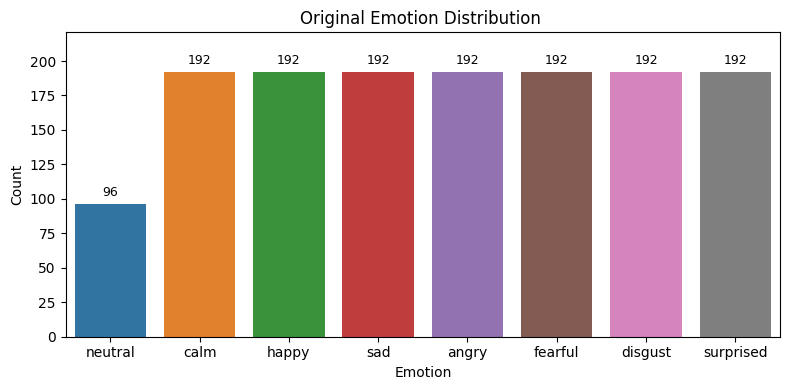

In [28]:
emotion_order =  ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotion_counts = df['emotion'].map(emotion_map).value_counts().sort_values()
emotion_counts = emotion_counts.reindex(emotion_order)

plt.figure(figsize=(8, 4))
sns.barplot(x=emotion_counts.index,
            y=emotion_counts.values,
            hue=emotion_counts.index,
            legend=False,
            palette='tab10'
)
plt.title("Original Emotion Distribution ")
plt.ylabel("Count")
plt.xlabel("Emotion")

max_val = max(emotion_counts.values)
plt.ylim(0, max_val * 1.15)

for i, v in enumerate(emotion_counts.values):
    plt.text(i, v + max_val * 0.02, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [30]:
#oversampling + pitch shift
def pitch_shift_audio(y, sr=22050, max_steps=2):
    steps = random.randint(-max_steps, max_steps)
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

In [32]:
#add noise
def add_noise(y, min_level=0.005, max_level=0.007):
    noise_level = np.random.uniform(min_level, max_level)
    noise = np.random.randn(len(y))
    augmented = y + noise_level * noise
    return augmented / np.max(np.abs(augmented))

In [31]:
#oversampling + pitch shift
df_copy = df.copy()
neutral_df = df_copy[df_copy['emotion'] == 1]
other_df = df_copy[df_copy['emotion'] != 1]

target_samples = 192
n_to_add = max(0, target_samples - len(neutral_df))

augmented = []
for _ in range(n_to_add):
    sample = neutral_df.sample(1, replace=True).iloc[0]
    y = sample['audio']
    sr = sample['sr']
    y_aug = pitch_shift_audio(y, sr)
    y_aug = np.array(y_aug, dtype=np.float32)

    new_sample = sample.copy()
    new_sample['audio'] = y_aug
    augmented.append(new_sample)

aug_df = pd.DataFrame(augmented)
aug_df['audio'] = aug_df['audio'].apply(lambda x: np.array(x) if isinstance(x, pd.Series) else x)
df_balanced = pd.concat([other_df, neutral_df, aug_df]).sample(frac=1, random_state=42).reset_index(drop=True)

In [33]:
#re-check balance
df_balanced['emotion'].value_counts()

,count
emotion,
5,192
3,192
8,192
1,192
4,192
6,192
7,192
2,192


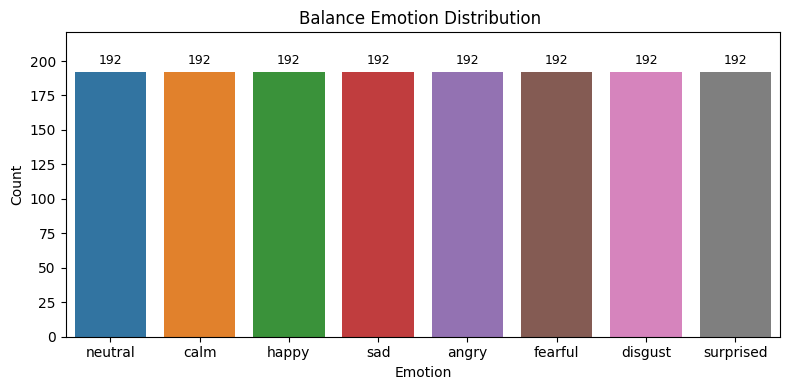

In [34]:
emotion_cnt = df_balanced['emotion'].map(emotion_map).value_counts().sort_values()
emotion_cnt = emotion_cnt.reindex(emotion_order)

plt.figure(figsize=(8, 4))
sns.barplot(x=emotion_cnt.index,
            y=emotion_cnt.values,
            hue=emotion_cnt.index,
            legend=False,
            palette='tab10'
)
plt.title("Balance Emotion Distribution ")
plt.ylabel("Count")
plt.xlabel("Emotion")

max_val = max(emotion_cnt.values)
plt.ylim(0, max_val * 1.15)

for i, v in enumerate(emotion_cnt.values):
    plt.text(i, v + max_val * 0.02, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [35]:
#Add noise
noisy_samples = []
for idx, row in df_balanced.iterrows():
    y = row['audio']
    sr = row['sr']
    y_noisy = add_noise(y)

    new_row = row.copy()
    new_row['audio'] = y_noisy
    noisy_samples.append(new_row)

df_noise = pd.DataFrame(noisy_samples)
df_final = pd.concat([df_balanced, df_noise], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_final = df_final.iloc[:,1:]
df_final = df_final[['emotion', 'audio']]

In [36]:
create_audio_widget(df_noise)

interactive(children=(Dropdown(description='Audio file:', layout=Layout(width='70%'), options=('RAVDESS/Actor_…

In [37]:
display(df_final.head())
print('Shape:',df_final.shape)

,emotion,audio
0,3,"[-0.006147204766886849, 0.0006253022764268406,..."
1,8,"[0.0011564451132780012, 0.0022119428405970123,..."
2,4,"[0.007450233229491666, 0.004955055012955842, -..."
3,5,"[-0.00061937125, -0.0009033937, -0.00091183925..."
4,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Shape: (3072, 2)


### 2. Feature extraction

In [23]:
def _pad_or_truncate(feat, max_len):
    T = feat.shape[1]
    if T < max_len:
        return np.pad(feat, ((0, 0), (0, max_len - T)), mode='constant')
    else:
        return feat[:, :max_len]

In [24]:
def standardize_clip(feat):
    return normalize(feat, norm='l2', axis=0)

In [26]:
def flatten_features(X):
    return X.reshape(X.shape[0], -1)

In [25]:
def extract_features_stacked(y, sr=22050, max_len=130):
    features = []

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = _pad_or_truncate(mfcc, max_len)
    mfcc = standardize_clip(mfcc)
    features.append(mfcc)

    # Mel
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = _pad_or_truncate(mel_db, max_len)
    mel_db = standardize_clip(mel_db)
    features.append(mel_db)

    # Stack and reshape
    features = np.stack(features, axis=0)  # shape: (2, 40, T)
    features = features.transpose(0, 2, 1)  # shape: (2, T, 40)
    return features

In [38]:
df_final['features'] = df_final['audio'].apply(lambda y: extract_features_stacked(y))
X = np.stack(df_final['features'].values, axis=0)  # shape: (N, 2, T, 40)
y = df_final['emotion'].values - 1

In [39]:
print(X.shape, y.shape) #X shape = (n_samples, n_methods, time, freq) | y shape = (n_samples, 1)
df_final['emotion'].value_counts()

(3072, 2, 130, 40) (3072,)


,count
emotion,
3,384
8,384
4,384
5,384
2,384
6,384
1,384
7,384


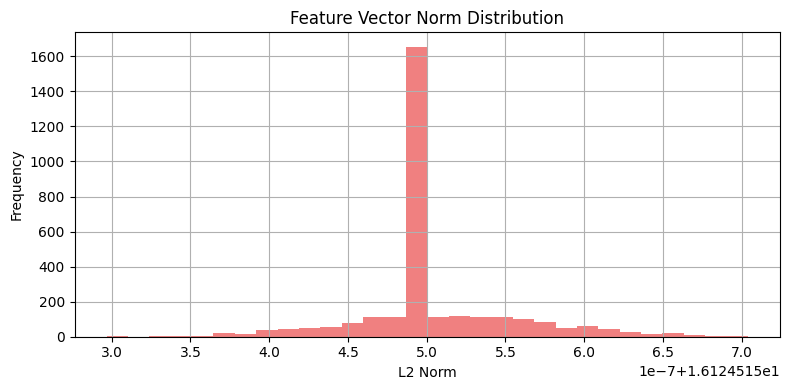

In [40]:
plt.figure(figsize=(8, 4))
plt.hist(np.linalg.norm(flatten_features(X), axis=1), bins=30, color='lightcoral')
plt.title("Feature Vector Norm Distribution")
plt.xlabel("L2 Norm")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

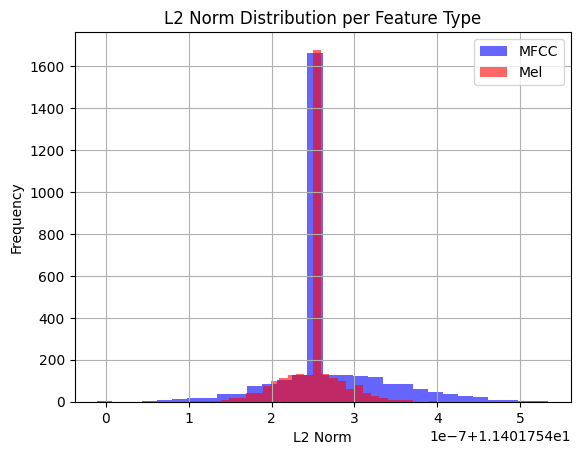

In [41]:
mfcc_norm = np.linalg.norm(X[:, 0], axis=(1, 2))
mel_norm = np.linalg.norm(X[:, 1], axis=(1, 2))

plt.hist(mfcc_norm, bins=30, alpha=0.6, label="MFCC", color='blue')
plt.hist(mel_norm, bins=30, alpha=0.6, label="Mel", color='red')
plt.title("L2 Norm Distribution per Feature Type")
plt.xlabel("L2 Norm")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

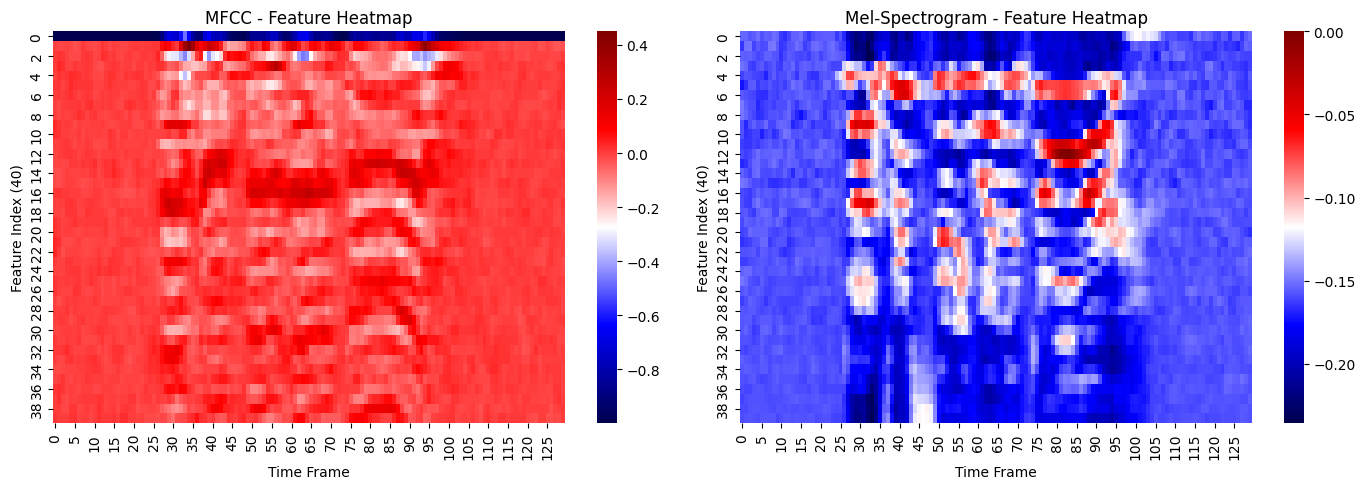

In [42]:
sample_idx = 0
sample = X[sample_idx]  # (2, 130, 40)
methods = ['MFCC', 'Mel-Spectrogram']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i in range(2):
    sns.heatmap(sample[i].T, ax=axes[i], cmap='seismic', cbar=True)
    axes[i].set_title(f"{methods[i]} - Feature Heatmap")
    axes[i].set_xlabel("Time Frame")
    axes[i].set_ylabel("Feature Index (40)")
plt.tight_layout()
plt.show()

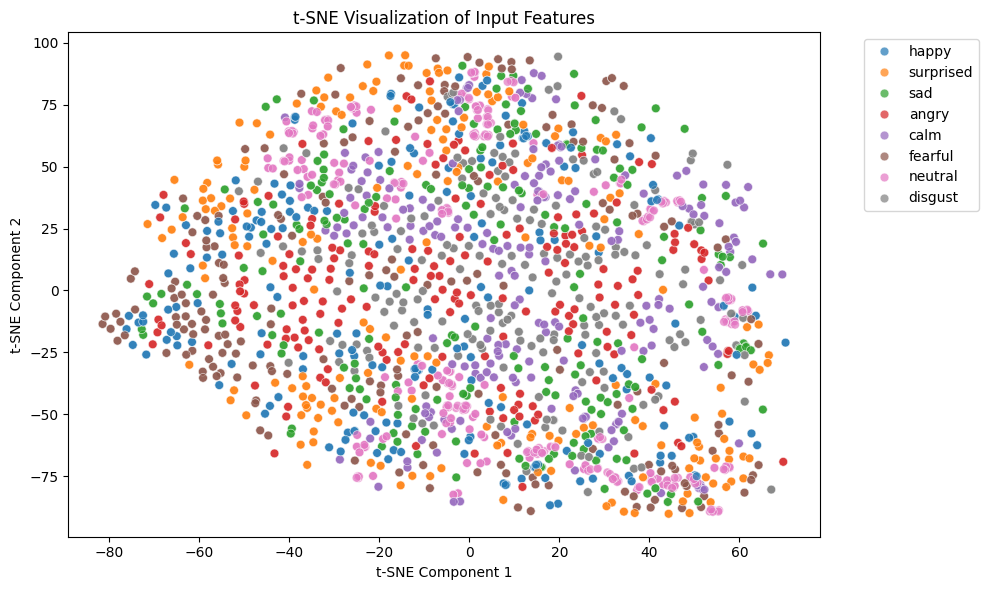

In [43]:
X_tmp = flatten_features(X)  # (n_samples, 10400)
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_tmp)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=[emotion_map[int(i) + 1] for i in y],
    palette='tab10',
    s=40,
    alpha=0.7
)

plt.title("t-SNE Visualization of Input Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## IV. Data preparation

### 1. Split dataset

In [44]:
#Mini-batch class
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [45]:
#Train/Test/Val split
X_reshape = X[:, np.newaxis, :, :, :]
X_train, X_temp, y_train, y_temp = train_test_split(X_reshape, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [46]:
X_train.shape

(2457, 1, 2, 130, 40)

### 2. Create Mini-batch

In [47]:
#Create mini-batch
train_loader = DataLoader(EmotionDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(EmotionDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader  = DataLoader(EmotionDataset(X_test, y_test), batch_size=32, shuffle=False)

In [48]:
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    break

Batch X shape: torch.Size([32, 1, 2, 130, 40])
Batch y shape: torch.Size([32])


## V. Build model

### 1. Initial model

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
class Pure3DCNN(nn.Module):
    def __init__(self, input_shape=(1, 2, 130, 40)):
        super(Pure3DCNN, self).__init__()
        C, D, T, F = input_shape
        self.conv1 = nn.Conv3d(C, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)

        # Output shape after conv3: (B, 64, D, T, F)
        self.flattened_size = 64 * D * T * F
        self.classifier = nn.Linear(self.flattened_size, 8)  # num_classes = 8

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (B, 16, 2, 130, 40)
        x = F.relu(self.conv2(x))  # (B, 32, 2, 130, 40)
        x = F.relu(self.conv3(x))  # (B, 64, 2, 130, 40)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)     # (B, 8)
        return x


In [51]:
model = Pure3DCNN(input_shape=(1, 2, 130, 40)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00013698702066031315)
criterion = nn.CrossEntropyLoss()
num_epochs = 100

In [ ]:
best_acc = 0
counter = 0
patience = 5

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []


for epoch in range(num_epochs):
    # ----- TRAIN -----
    model.train()
    train_loss, train_preds, train_labels = 0, [], []
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(output.argmax(dim=1).cpu().numpy())
        train_labels.extend(batch_y.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    train_loss /= len(train_loader)

    # ----- VALIDATION -----
    model.eval()
    val_loss, val_preds, val_labels = 0, [], []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)
            val_loss += loss.item()
            val_preds.extend(output.argmax(dim=1).cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_loss /= len(val_loader)

    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        best_model = deepcopy(model.state_dict())
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopped at epoch {epoch}")
            break

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)


    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 01 | Train Loss: 1.9849 | Train Accuracy: 0.2153 | Val Loss: 1.7317 | Val Accuracy: 0.3648
Epoch 02 | Train Loss: 1.4292 | Train Accuracy: 0.4912 | Val Loss: 1.2563 | Val Accuracy: 0.5407
Epoch 03 | Train Loss: 0.9730 | Train Accuracy: 0.6732 | Val Loss: 0.9561 | Val Accuracy: 0.6775
Epoch 04 | Train Loss: 0.6086 | Train Accuracy: 0.7961 | Val Loss: 0.6948 | Val Accuracy: 0.7590
Epoch 05 | Train Loss: 0.3763 | Train Accuracy: 0.8873 | Val Loss: 0.6305 | Val Accuracy: 0.7590
Epoch 06 | Train Loss: 0.2085 | Train Accuracy: 0.9451 | Val Loss: 0.4352 | Val Accuracy: 0.8567
Epoch 07 | Train Loss: 0.1088 | Train Accuracy: 0.9735 | Val Loss: 0.4360 | Val Accuracy: 0.8632
Epoch 08 | Train Loss: 0.0837 | Train Accuracy: 0.9809 | Val Loss: 0.3750 | Val Accuracy: 0.8925
Epoch 09 | Train Loss: 0.0387 | Train Accuracy: 0.9955 | Val Loss: 0.2899 | Val Accuracy: 0.9349
Epoch 10 | Train Loss: 0.0159 | Train Accuracy: 0.9988 | Val Loss: 0.3039 | Val Accuracy: 0.9218
Epoch 11 | Train Loss: 0.0086 

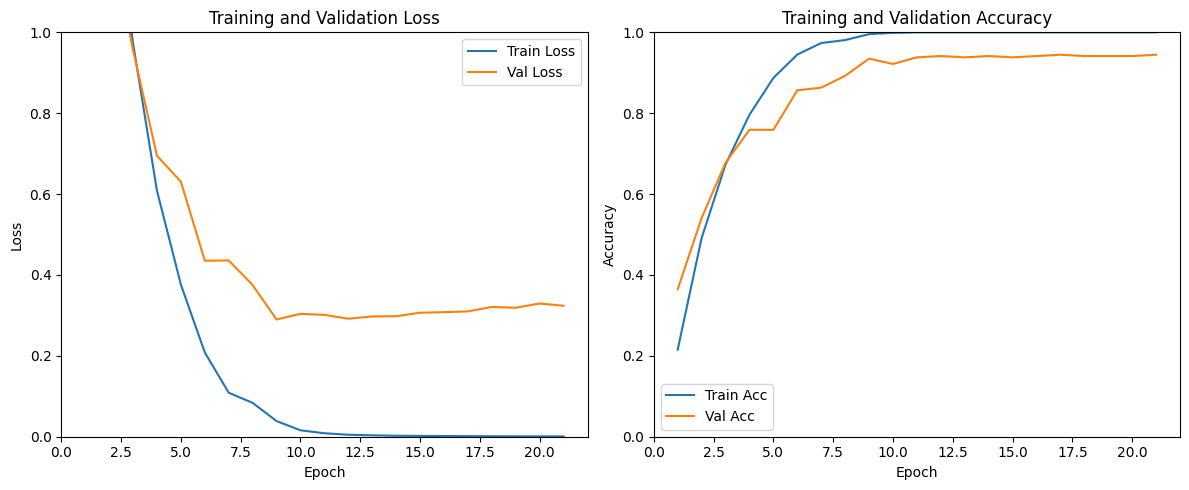

In [ ]:
epochs_range = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 1)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_list, label='Train Acc')
plt.plot(epochs_range, val_acc_list, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



Test Accuracy: 0.9545

Classification Report:
              precision    recall  f1-score   support

     neutral     1.0000    0.9737    0.9867        38
        calm     0.9048    1.0000    0.9500        38
       happy     0.9444    0.8947    0.9189        38
         sad     0.9474    0.9231    0.9351        39
       angry     0.9737    0.9487    0.9610        39
     fearful     0.9268    0.9744    0.9500        39
     disgust     1.0000    0.9474    0.9730        38
   surprised     0.9500    0.9744    0.9620        39

    accuracy                         0.9545       308
   macro avg     0.9559    0.9545    0.9546       308
weighted avg     0.9558    0.9545    0.9546       308



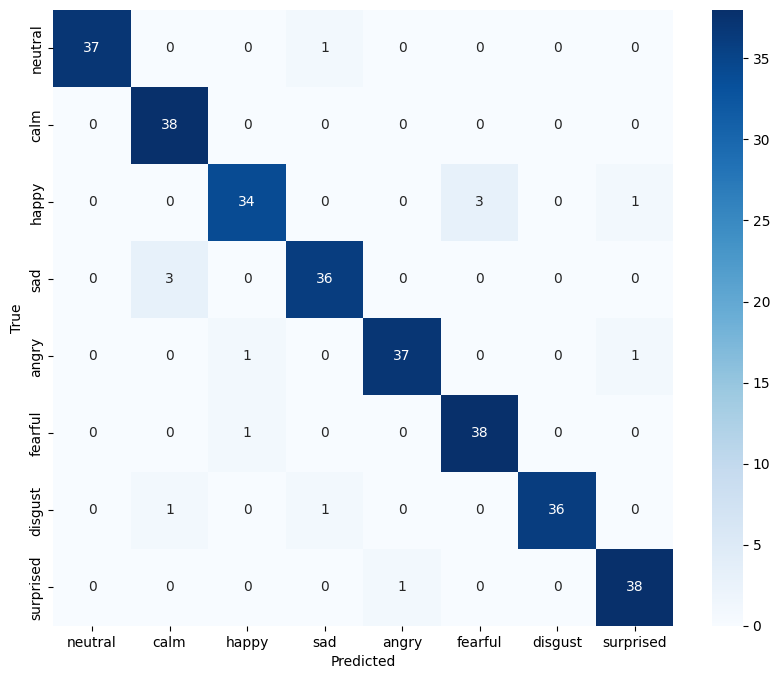

In [ ]:
model.load_state_dict(best_model)
model.eval()

labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

all_preds, all_labels = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        output = model(batch_X)
        preds = output.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4, target_names=labels))

conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(len(labels)))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 2. Custom model

In [52]:
class Conv3D(nn.Module):
    def __init__(
        self,
        num_classes=8,
        conv_channels=[32, 64, 128, 128, 256],
        dropout=0.3,
        fc_dim=128,
        input_shape=(1, 2, 130, 40)  # (C, D, T, F)
    ):
        super().__init__()

        self.conv_layers = nn.Sequential()
        in_channels = input_shape[0]

        for i, out_channels in enumerate(conv_channels):
            self.conv_layers.add_module(f"conv3d_{i}", nn.Conv3d(
                in_channels, out_channels, kernel_size=(3, 3, 3), padding=1
            ))
            self.conv_layers.add_module(f"gn_{i}", nn.GroupNorm(num_groups=4, num_channels=out_channels))
            self.conv_layers.add_module(f"relu_{i}", nn.ReLU())
            self.conv_layers.add_module(f"dropout3d_{i}", nn.Dropout3d(p=0.1))
            self.conv_layers.add_module(f"pool_{i}", nn.MaxPool3d(kernel_size=(1, 2, 2)))  # giảm freq & time
            in_channels = out_channels

        # Global pooling để cố định output size
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))

        # Tính dimension sau conv
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy_out = self.global_pool(self.conv_layers(dummy))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]

        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(self.flatten_dim, fc_dim)
        self.fc2 = nn.Linear(fc_dim, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

### 3. Tuning hyperparameter

In [53]:
def build_model(trial):
    conv1 = trial.suggest_categorical("conv1", [16, 32, 64])
    conv2 = trial.suggest_categorical("conv2", [32, 64, 128])
    conv3 = trial.suggest_categorical("conv3", [64, 128])
    conv4 = trial.suggest_categorical("conv4", [128, 256])
    conv5 = trial.suggest_categorical("conv5", [128, 256, 384])

    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    fc_dim = trial.suggest_categorical("fc_dim", [64, 128, 256])

    conv_channels = [conv1, conv2, conv3, conv4, conv5]

    model = Conv3D(
        num_classes=8,
        conv_channels=conv_channels,
        dropout=dropout,
        fc_dim=fc_dim
    )

    return model

In [54]:
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_model(trial).to(device)

    # Hyperparameter
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    patience = 5
    counter = 0
    max_epochs = 30

    for epoch in range(max_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                out = model(batch_X)
                preds = out.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(batch_y.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        trial.report(val_acc, step=epoch)

        # Early stop nếu Optuna yêu cầu
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stopping logic thủ công
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    return best_val_acc

In [ ]:
study_hyperparam = optuna.create_study(direction="maximize")
study_hyperparam.optimize(objective, n_trials=50)

best_trial = study_hyperparam.best_trial
print(best_trial.number)
print(best_trial.value)
print(best_trial.params)

### 4. Training custom model

In [ ]:
set_seed(24)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 100

model = Conv3D(
    num_classes=8,
    conv_channels=[16, 128, 64, 256, 128],
    dropout=0.21423968438102473,
    fc_dim=128,
    input_shape=(1, 2, 130, 40)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr= 0.00013698702066031315)
criterion = nn.CrossEntropyLoss()

best_acc = 0
counter = 0
patience = 5

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(num_epochs):
    # ----- TRAIN -----
    model.train()
    train_loss, train_preds, train_labels = 0, [], []
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(output.argmax(dim=1).cpu().numpy())
        train_labels.extend(batch_y.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    train_loss /= len(train_loader)

    # ----- VALIDATION -----
    model.eval()
    val_loss, val_preds, val_labels = 0, [], []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)
            val_loss += loss.item()
            val_preds.extend(output.argmax(dim=1).cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_loss /= len(val_loader)

    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        best_model = deepcopy(model.state_dict())
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopped at epoch {epoch}")
            break

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    # ----- LOG -----
    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        output = model(batch_X)
        preds = output.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

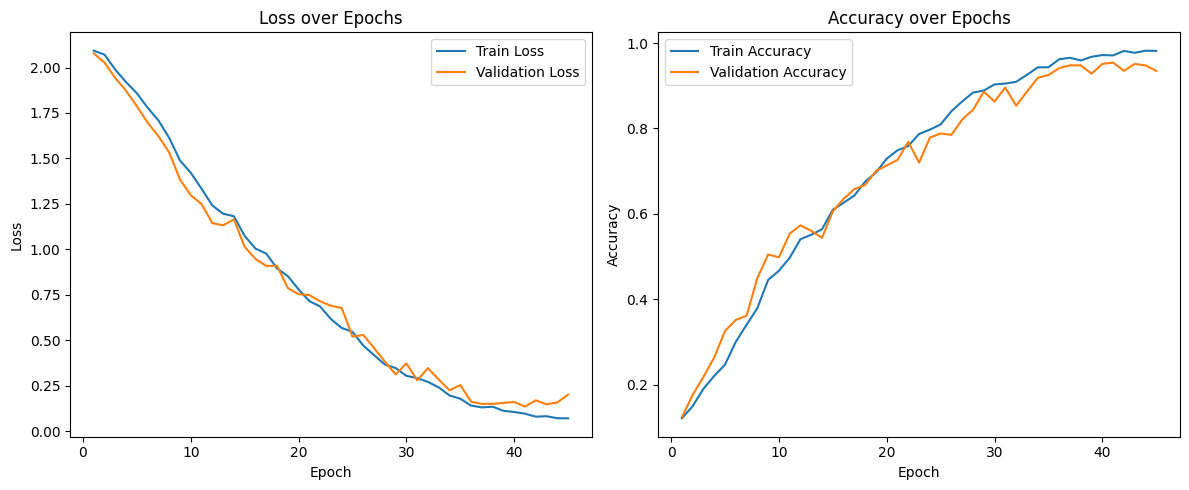

In [ ]:
epochs_range = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        output = model(batch_X)
        preds = output.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4, target_names=labels))


Test Accuracy: 0.9545

Classification Report:
              precision    recall  f1-score   support

     neutral     0.9744    1.0000    0.9870        38
        calm     0.9048    1.0000    0.9500        38
       happy     0.9730    0.9474    0.9600        38
         sad     0.9444    0.8718    0.9067        39
       angry     0.8864    1.0000    0.9398        39
     fearful     1.0000    0.9487    0.9737        39
     disgust     1.0000    0.8684    0.9296        38
   surprised     0.9750    1.0000    0.9873        39

    accuracy                         0.9545       308
   macro avg     0.9572    0.9545    0.9543       308
weighted avg     0.9572    0.9545    0.9542       308



### 5. Custom model evaluation

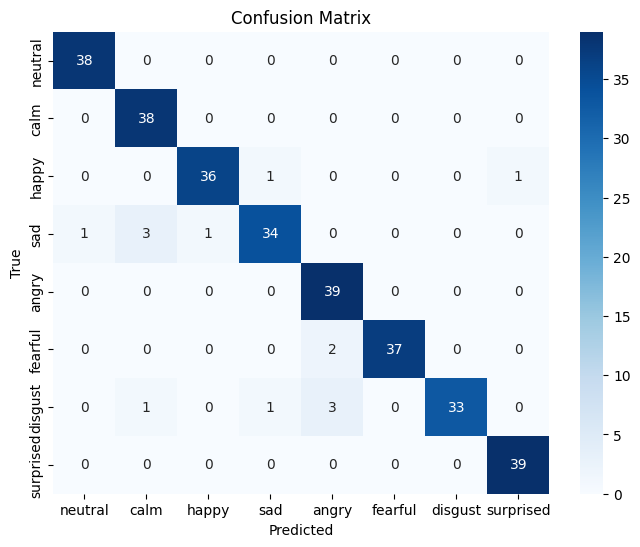

In [ ]:
cm = confusion_matrix(all_labels, all_preds, labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#save model
torch.save(model, "3DCNN_modelV2_fixed.pt")

C:\Users\thoai\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


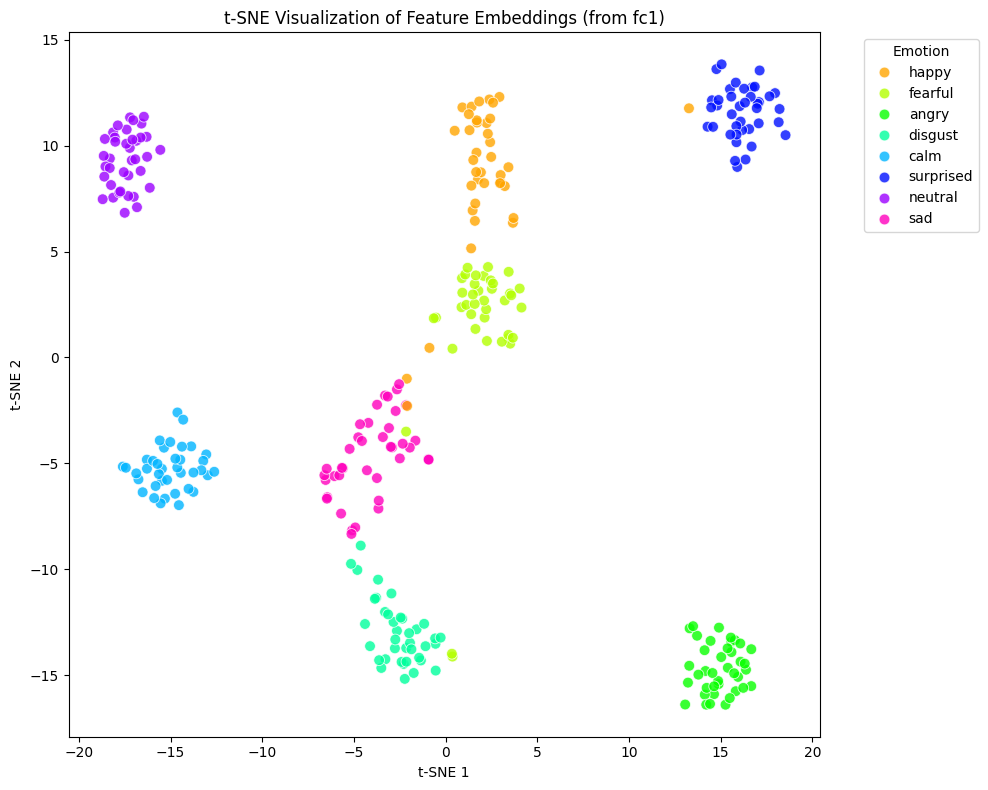

In [ ]:
features = []
labels_list = []

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        # Forward tới fc1
        x = model.conv_layers(X)
        x = model.global_pool(x)
        x = x.view(x.size(0), -1)
        x = model.dropout(x)
        x = model.fc1(x)  # <- lấy output fc1 làm feature embedding

        features.append(x.cpu().numpy())
        labels_list.extend(y.cpu().numpy())

# Stack toàn bộ đặc trưng
features = np.vstack(features)
labels_list = np.array(labels_list)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(features)

# plot
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(labels))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=[labels[i] for i in labels_list],
                palette=palette, s=60, alpha=0.8)
plt.title("t-SNE Visualization of Feature Embeddings (from fc1)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title='Emotion')
plt.tight_layout()
plt.show()
